In [1]:
from __future__ import print_function, division
from builtins import range, input

import os, sys
import keras.backend as K

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt


In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-03-11 05:16:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-11 05:16:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-11 05:16:52--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [20]:
!unzip '/content/glove.6B.zip'

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
NUM_SAMPLES = 10000
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64
EPOCHS = 40
LATENT_DIM = 256

In [22]:
input_texts = []
target_texts = []
target_texts_inputs = []

t = 0
for line in open('/content/spa.txt'):
  t += 1
  if t > NUM_SAMPLES:
    break
  if '\t' not in line:
    continue
  input_text, translation, *rest = line.rstrip().split('\t')
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print(len(input_texts))

10000


In [23]:
tokenizer_inputs = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)
word2idx_inputs = tokenizer_inputs.word_index

max_len_input = max(len(s) for s in input_sequences)

tokenizer_outputs = Tokenizer(num_words = MAX_NUM_WORDS, filters = '')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)
word2idx_outputs = tokenizer_outputs.word_index
num_words_output = len(word2idx_outputs) + 1
max_len_target = max(len(s) for s in target_sequences)

encoder_inputs = pad_sequences(input_sequences, maxlen = max_len_input)
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen = max_len_target, padding='post')
decoder_targets = pad_sequences(target_sequences, maxlen = max_len_target, padding='post')


In [24]:
word2vec = {}
with open('/content/glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype = 'float32')
    word2vec[word] = vec

num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights = [embedding_matrix], 
                            input_length = max_len_input)

In [25]:
decoder_targets_onehot = np.zeros((len(input_texts), max_len_target, num_words_output),
                                  dtype = 'float32')
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_onehot[i, t, word] = 1

In [34]:
encoder_inputs_placeholder = Input((max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LATENT_DIM, return_state=True,)
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]
decoder_inputs_placeholder = Input((max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True,)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state = encoder_states)
decoder_dense = Dense(num_words_output, activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [35]:
def custom_loss(y_true, y_pred):
  mask = K.cast(y_true > 0, dtype = 'float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)

def acc(y_true, y_pred):
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

In [36]:
r = model.fit([encoder_inputs, decoder_inputs], decoder_targets_onehot,
              batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = 0.2)

Epoch 1/40
125/125 [==============================] - 64s 488ms/step - loss: 6.6730 - acc: 0.2602 - val_loss: 5.6467 - val_acc: 0.2526
Epoch 2/40
125/125 [==============================] - 59s 474ms/step - loss: 4.8979 - acc: 0.3030 - val_loss: 5.3860 - val_acc: 0.2721
Epoch 3/40
125/125 [==============================] - 59s 473ms/step - loss: 4.4304 - acc: 0.3358 - val_loss: 5.1435 - val_acc: 0.3176
Epoch 4/40
125/125 [==============================] - 59s 476ms/step - loss: 3.9921 - acc: 0.3897 - val_loss: 4.9801 - val_acc: 0.3522
Epoch 5/40
125/125 [==============================] - 60s 479ms/step - loss: 3.5855 - acc: 0.4377 - val_loss: 4.8655 - val_acc: 0.3743
Epoch 6/40
125/125 [==============================] - 60s 483ms/step - loss: 3.2427 - acc: 0.4639 - val_loss: 4.7687 - val_acc: 0.3953
Epoch 7/40
125/125 [==============================] - 60s 477ms/step - loss: 2.9549 - acc: 0.4962 - val_loss: 4.7213 - val_acc: 0.4062
Epoch 8/40
125/125 [==============================] - 5

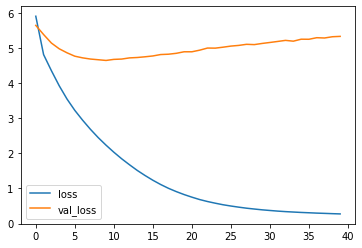

In [37]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

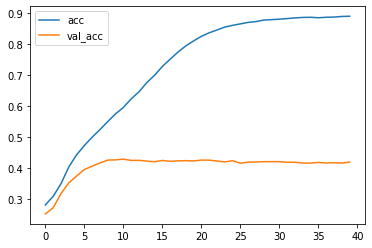

In [38]:
model.save('s2s.h5')
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [39]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)
decoder_stateinput_h = Input((LATENT_DIM,))
decoder_stateinput_c = Input((LATENT_DIM,))
decoder_states_inputs = [decoder_stateinput_h, decoder_stateinput_c]

decoder_inputs_single = Input((1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, 
                                     initial_state=decoder_states_inputs)
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, 
                      [decoder_outputs] + decoder_states)
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

def decode_sequence(input_seq):
  states_value = encoder_model.predict(input_seq)

  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = word2idx_outputs['<sos>']

  eos = word2idx_outputs['<eos>']

  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    idx = np.argmax(output_tokens[0, 0, :])
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    target_seq[0, 0] = idx
    states_value = [h, c]

  return ' '.join(output_sentence)


In [40]:
while True:
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: I failed.
Translation: fallé.
Continue? [Y/n]y
-
Input: I hate insects.
Translation: odio a los insectos.
Continue? [Y/n]y
-
Input: You go first.
Translation: tú primero.
Continue? [Y/n]y
-
Input: I miss it.
Translation: lo echo de menos.
Continue? [Y/n]n
